Il seguente codice è la versione finale che permette la riproduzione delle immagini della dissertazione. Spesso si fa utilizzo di dati e parametri importati dal google drive personale. Assicurarsi di averli salvati nel proprio Drive (scaricandoli da GitHub prima di eseguire le celle corrispondenti

#Caricamento Dataset e librerie

In questa sezione viene caricato dinamicamente il dataset utilizzato in modo da non riempire la ram gestita da Google. Viene anche effettuato il downsample del dataset riducendolo fino ad immagini 28x28 in bianco e nero.

In [ ]:
!pip install torchmetrics
!pip install astroNN torch

from astroNN.datasets import load_galaxy10
import numpy as np
import matplotlib.pyplot as plt
import h5py  # Per gestire file HDF5 del dataset

# Librerie PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset,TensorDataset
import torch.optim as optim
from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure  # Per metriche

#Librerie Pennylane
!pip install pennylane
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Definizione della funzione per convertire immagini RGB in scala di grigi
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# Definizione del dataset personalizzato con ridimensionamento e conversione in bianco e nero
class Galaxy10Dataset(Dataset):
    def __init__(self, hdf5_file, target_size=(28, 28), to_gray=True):

        with h5py.File(hdf5_file, 'r') as f:
            self.images = f['images'][:]  # Carica tutte le immagini
            self.labels = f['labels'][:]  # Carica tutte le etichette (potrebbero essere necessarie per effettuare studi metrici sui risultati come t-SNE ecc...)

        self.to_gray = to_gray  # Flag per conversione in bianco e nero

        #Definizione del downsampling
        self.transform = transforms.Compose([
            transforms.ToPILImage(),        # Converte da Tensor a PIL Image
            transforms.Resize(target_size), # Downsample fino a target_size
            transforms.ToTensor()           # Converte di nuovo a Tensor
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Normalizza l'immagine tra 0 e 1 e la converte in tensor PyTorch
        image = self.images[idx] / 255.0

        #Conversione in scala di grigi
        if self.to_gray:
            image = rgb2gray(image)
            image = np.expand_dims(image, axis=-1)  # Aggiunge il canale per la scala di grigi

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Cambia l'ordine dei canali

        # Applica il downsample
        image = self.transform(image)

        # Restituisce l'immagine
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


images, labels = load_galaxy10()
hdf5_file = 'Galaxy10_DECals.h5'
with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=images)  # Salva le immagini
    f.create_dataset('labels', data=labels)  # Salva le etichette
del images, labels #Per alleggerire la ram

galaxy_dataset = Galaxy10Dataset(hdf5_file, to_gray=True)
dataloader = DataLoader(galaxy_dataset, batch_size=32, shuffle=True)


In [ ]:
#Esempio di immagine del dataset downsampled
batch = next(iter(dataloader))
plt.imshow(np.transpose(batch[0][17].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
plt.axis('off')
plt.show()


#AE classico

##Definizione

In [ ]:
#DEFINIZIONE DELL'ENCODER
class Encoder(nn.Module):
    def __init__(self, hidden_channels=32, latent_dim=64):
        super().__init__()

        # Strato convoluzionale iniziale
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Layer convoluzionale extra
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Seconda convoluzione
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Flatten e riduzione a vettore di dimensione 64
        self.fc_z = nn.Linear(in_features=hidden_channels*2*7*7, out_features=latent_dim)  # 7x7 -> 64

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)  # Flatten
        z = self.fc_z(x)
        z = F.normalize(z, p=2, dim=-1)  # Normalizza il vettore latente
        return z

#DEFINIZIONE DEL DECODER
class Decoder(nn.Module):
    def __init__(self, hidden_channels=32, latent_dim=64):
        super().__init__()


        self.fc = nn.Linear(in_features=latent_dim, out_features=hidden_channels*2*7*7)

        # Strato convoluzionale iniziale
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels*2, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Layer convoluzionale extra
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14 (solo convoluzione)
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Secondo strato trasposto
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Per riportare l'output nell'intervallo [0, 1]
        )

    def forward(self, z):
        z = z.view(z.size(0), -1)  # Flatten
        z = self.fc(z)
        z = z.view(z.size(0), 32*2, 7, 7)  # Reshape per il primo deconv

        z = self.deconv1(z)
        z = self.conv(z)  # Convoluzione extra
        z = self.deconv2(z)

        return z

#CLASSE PYTORCH CON ENCODER E AUTOENCODER
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(latent_dim=64)
        self.decoder = Decoder(latent_dim=64)

    def forward(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


##Training

In [ ]:
#TRAINING CON MONITORAGGIO IMMAGINI
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, img1, img2):
        # 1 - SSIM per usarlo come una funzione di perdita
        return 1 - structural_similarity_index_measure(img1, img2)



def train(autoencoder, dataloader, criterion, optimizer, num_epochs, device):
  autoencoder.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for img, _ in dataloader:
        img = img.to(device)
        latent_vectors = autoencoder.encoder(img)
        output = autoencoder.decoder(latent_vectors)
        loss =criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * img.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f'Epoca [{epoch+1}/{num_epochs}], Perdita: {avg_loss:.4f}')

    # Visualizza immagini ultima epoche
    if (epoch + 1) % 10 == 0:
        # Mostra alcune immagini originali
        img_grid = torchvision.utils.make_grid(img.cpu().detach(), nrow=8, padding=2, normalize=True)
        imshow(img_grid, title="Originali")

        # Mostra le immagini ricostruite
        output_grid = torchvision.utils.make_grid(output.cpu().detach(), nrow=8, padding=2, normalize=True)
        imshow(output_grid, title="Ricostruite")


In [ ]:
batch_size = 32
learning_rate = 3e-4
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder().to(device)  # Trasferisce il modello al device
criterion = SSIMLoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
train(autoencoder, dataloader, criterion, optimizer, num_epochs, device)

###Salvataggio AE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Poi salva il file nel percorso di Google Drive
torch.save(autoencoder.state_dict(), '/content/drive/MyDrive/autoencoder.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Salvataggio dataset compresso

In [ ]:
import os
encoder=autoencoder.encoder
decoder=autoencoder.decoder
encoded_images_dir = '/content/drive/MyDrive/encoded_images'
os.makedirs(encoded_images_dir, exist_ok=True)

for i, (images, _) in enumerate(dataloader):
    # Passare le immagini nell'encoder
    images=images.to(device)
    encoded_images = encoder(images)

    # Salvare ogni immagine encodata nella cartella
    for j, encoded_image in enumerate(encoded_images):
        # Definire il nome del file
        file_path = os.path.join(encoded_images_dir, f'encoded_image_{i}_{j}.pth')

        # Salvare il tensore
        torch.save(encoded_image.cpu().detach(), file_path)

##Caricamento AE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/autoencoder.pth'))  # Carica i pesi salvati
autoencoder.to(device)
autoencoder.eval()  # Passa il modello in modalità di valutazione
encoder=autoencoder.encoder
decoder=autoencoder.decoder
encoder.eval()
decoder.eval()

dim_latent=64



class Decoder_esterno(nn.Module):
    def __init__(self, hidden_channels=64):
        super().__init__()

        self.fc = nn.Linear(in_features=1*28*28, out_features=hidden_channels*4*16*16)

        # Primo blocco di deconvoluzione: 16x16 -> 32x32
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels*4, out_channels=hidden_channels*2, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Secondo blocco di deconvoluzione: 32x32 -> 64x64
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels*2, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Terzo blocco di deconvoluzione: 64x64 -> 128x128
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Quarto blocco di deconvoluzione: 128x128 -> 256x256
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=3, kernel_size=4, stride=2, padding=1)  # 128x128 -> 256x256
        )

        self.output_activation = nn.Sigmoid()  # Per riportare l'output nell'intervallo [0, 1]

    def forward(self, z):
        z = z.view(z.size(0), -1)  # Flatten (batch_size, 1*28*28)

        z = self.fc(z)
        z = z.view(z.size(0), 64*4, 16, 16)

        z = self.deconv1(z)  # 16x16 -> 32x32
        z = self.deconv2(z)  # 32x32 -> 64x64
        z = self.deconv3(z)  # 64x64 -> 128x128
        z = self.deconv4(z)  # 128x128 -> 256x256
        z = self.output_activation(z)

        return z

from google.colab import drive
drive.mount('/content/drive')

decoder_ext=Decoder_esterno()
decoder_ext.load_state_dict(torch.load('/content/drive/MyDrive/Decoder_esterno.pth'))  # Carica i pesi salvati
decoder_ext.to(device)
decoder_ext.eval()  # Passa il modello in modalità di valutazione

Mounted at /content/drive


<ipython-input-4-6c1a0ccbf85f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/28x28_BW/autoencoder.pth'))  #

##Caricamento dati

Le due celle seguenti svolgono il medesimo compito, talvolta una delle due potrebbe non funzionare o richiedere troppo tempo per il terminamento in base alla condizioni della rete ed altri fattori dipendenti da google.

In [ ]:
!cp -r '/content/drive/My Drive/encoded_images' /content/encoded_img

In [ ]:
import os
#encoded_images_dir = '/content/encoded_img'
encoded_images_dir = '/content/drive/My Drive/encoded_images'

# Lista dei file nella cartella
image_files = [f for f in os.listdir(encoded_images_dir) if f.endswith('.pth')]

# Lista in cui salvare i tensori delle immagini
tensors = []
i=1
for image_file in image_files:
    # Percorso completo dell'immagine
    image_path = os.path.join(encoded_images_dir, image_file)


    tensor = torch.load(image_path, weights_only=True)
    if (i%4429==0): print("Siamo al:",np.round((i/17736)*100),"% di immagini caricate.")
    # Aggiunge il tensore alla lista
    tensors.append(tensor)
    i=i+1

# Stack delle immagini in un unico tensore
tensors = torch.stack(tensors)
tensors=tensors.squeeze()
tensors=tensors.reshape(-1,64)
dim_latent=64
print(f"Caricate {tensors.size(0)} immagini in un tensore di dimensioni {tensors.size()}")

##Esempio decoder

In [ ]:
batch = next(iter(dataloader))
with torch.no_grad():
 output=autoencoder(batch[0].to(device))

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
a=np.random.randint(0,8)
for i in range(8):
  axs[0, i].imshow(np.transpose(batch[0][i].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
  axs[0, i].axis('off')
  axs[1, i].imshow(np.transpose(output[i].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
  axs[1, i].axis('off')
axs[0, 0].set_title('Originali')
axs[1, 0].set_title('Ricostruite')
plt.show()

###Esempio su puro rumore normalizzato

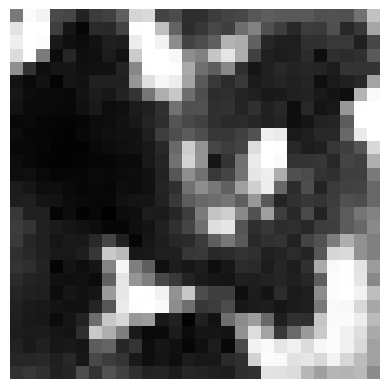

In [ ]:
noise=np.random.normal(0,1,size=(dim_latent))+1j*np.random.normal(0,1,size=(dim_latent))
with torch.no_grad():
    noise_tensor = torch.tensor(noise, dtype=torch.complex64).to(device)
    noise_tensor = noise_tensor.view(1, -1)
    normalized_noise = F.normalize(noise_tensor.real, p=2, dim=0).float()
    img = decoder(normalized_noise)

    plt.imshow(img.cpu().detach().numpy().squeeze(0).transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

Il decoder da solo non reisce a effettuare il denoising. Pertanto si ha la certezza che questo viene effettuato proprio dal circuito quantistico.

#Forward Markov chain

step di rumore generico

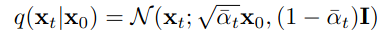

step di rumore da t-1 a t

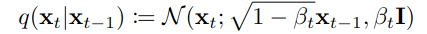

##Schedule rumore

In [ ]:
n_step=15

###Cosine schedule

In [ ]:
alpha_bar=((np.cos((((np.arange(n_step+1))/n_step+0.008)/(1.008))*0.5*np.pi))**2)/((np.cos(0.008/1.008*0.5*np.pi))**2)
beta=1.0-alpha_bar[np.arange(n_step+1)]/alpha_bar[np.arange(n_step+1)-1]
beta[0]=0
beta [n_step]=0.999
lin=1

###Linear schedule

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n_step=15

beta=(0.2-0.001)/(n_step-1)*(np.arange(n_step))+0.001
beta=np.insert(beta,0,0)
alpha_bar = np.cumprod(1 - beta)
lin=0

###Plot

In [ ]:
x=np.linspace(0,n_step,100)
y= np.cumprod(1 - ((0.2-0.001)/(n_step-1)*x+0.001))
plt.plot(x/n_step,((np.cos((((x/n_step+0.008)/(1.008))*0.5*np.pi))**2)/((np.cos(0.008/1.008*0.5*np.pi))**2)),label='coseno',color="mediumseagreen")
plt.plot(x/n_step,y,label='lineare',color="mediumslateblue")
plt.legend()
plt.show()

##Normalizzazione dati iniziali

##Catena di Markov sui dati

In [ ]:
#Stretching dello spazio latente
tensors_normed=(tensors - tensors.min()) / (tensors.max() - tensors.min())

In [ ]:
def x_t(images,alpha_bar,t):
  target_images = torch.from_numpy(np.sqrt(alpha_bar[t])[:, np.newaxis] * images.cpu().numpy() + np.sqrt(1 - alpha_bar[t])[:, np.newaxis] * (np.random.normal(0, 1, size=(t.shape[0],64))+1j*np.random.normal(0, 1, size=(t.shape[0],64))))
  target_state=target_images.reshape(-1,64)
  return target_state
def x_tplus(images,beta,t):
   initial_images= torch.from_numpy(np.sqrt(1-beta[t+1])[:, np.newaxis] * images.cpu().numpy() + np.sqrt(beta[t+1])[:, np.newaxis] * (np.random.normal(0, 1, size=(t.shape[0],64))+1j*np.random.normal(0, 1, size=(t.shape[0],64))))
   initial_state=initial_images.reshape(-1,64)
   return initial_state

#PQC

##Definizione Circuito

In [ ]:
#Definizione dei blocchi
dev6 = qml.device('default.qubit', wires=6)
dev7 = qml.device('default.qubit', wires=7)
# Numero di qubit
n_qubits = 6

In [ ]:
#Circuiti parametrici

@qml.qnode(dev6, interface='torch')
def circuitU1(state,params_U1):
    qml.AmplitudeEmbedding(state, wires=range(n_qubits), normalize=False)
    # Blocco U1: StronglyEntanglingLayers su 8 qubit
    qml.StronglyEntanglingLayers(weights=params_U1, wires=range(n_qubits))
    return qml.state()

@qml.qnode(dev7, interface='torch')
def circuitU2(state,params_U2):
  qml.AmplitudeEmbedding(state, wires=range(n_qubits+1), normalize=False)
  # Blocco U2: StronglyEntanglingLayers su 8 qubit + ancilla
  qml.StronglyEntanglingLayers(weights=params_U2, wires=range(n_qubits +1))

  return qml.state()

@qml.qnode(dev6, interface='torch')
def circuitU3(state,params_U3):
  qml.AmplitudeEmbedding(state, wires=range(n_qubits), normalize=False)
  #Blocco U3: StronglyEntanglingLayers su 8 qubit
  qml.StronglyEntanglingLayers(weights=params_U3, wires=range(n_qubits))
  return qml.state()

In [ ]:
class Circuito(nn.Module):
    def __init__(self):
        super(Circuito, self).__init__()
        self.circuit1 = circuitU1
        self.circuit2 = circuitU2
        self.circuit3 = circuitU3

        self.param1 = nn.Parameter(torch.randn(30, n_qubits, 3))
        self.param2 = nn.Parameter(torch.randn(40, n_qubits+1, 3))
        self.param3 = nn.Parameter(torch.randn(30, n_qubits, 3))

    def forward(self, x):
        stato_ini_norm=torch.nn.functional.normalize(x, p=2,dim=1)
        stato1 = self.circuit1(stato_ini_norm, self.param1)  #Passa l'input e i parametri al primo circuito

        stato1_ancilla=torch.cat((stato1,torch.zeros_like(stato1).to(device)), dim=1) #Aggiunge l'ancilla
        stato1_norm=torch.nn.functional.normalize(stato1_ancilla, p=2,dim=1)
        stato2 = self.circuit2(stato1_norm, self.param2)  #Passa l'output del primo con ancilla nel secondo
        stato2_BS=stato2[:,:dim_latent]

        stato2_norm=torch.nn.functional.normalize(stato2_BS, p=2,dim=1) # norma L2 = 1

        stato3 = self.circuit3(stato2_norm,self.param3)  #Passa l'output del secondo nel terzo
        return stato3

##Training

In [ ]:
dataset = TensorDataset(tensors_normed)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
n_epochs = 5
step=14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
circuito = Circuito().to(device)
circuito.train()

optimizer = torch.optim.Adam(circuito.parameters(), lr=0.0003)

def infidelity_loss (prediction,target):
 fidelity = torch.abs(torch.sum(torch.conj(prediction) *torch.nn.functional.normalize(target, p=2,dim=1) , dim=-1)) ** 2
 infidelity=1-fidelity.mean()
 return infidelity

if(lin==0):print("LINEAR SCHEDULE")
else:print("COSINE SCHEDULE")

for epoch in range(n_epochs):
  epoch_loss=0
  for batch_immagini in dataloader:
    optimizer.zero_grad()
    t = np.ones(batch_immagini[0].shape[0],dtype=int)*step
    batch_target = x_t(batch_immagini[0],alpha_bar ,t).to(device)
    batch_initial = x_tplus(batch_target, beta,t).to(device)#t+1 lo fa direttamente nella funzione x_tplus
    prediction = circuito(batch_initial)
    loss = infidelity_loss(prediction, batch_target)
    loss.backward()
    optimizer.step()
    epoch_loss+=loss.item()
  avg_loss=epoch_loss/len(dataloader)
  print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")



E' possibile adattare il training in modo da addestrare un solo circuito per tutti i 15 step di denoising. Per fare ciò va sostituito

t = np.ones(batch_immagini[0].shape[0],dtype=int)*step

con un batch di t randomici che variano ogni epoca.

###Salvataggio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Salvo il file nel percorso di Google Drive
torch.save(circuito.state_dict(), '/content/drive/MyDrive/circuito_t_tplus.pth')

##Generazione

In [ ]:
#Vanno importati i parametri dei circuiti
from google.colab import drive
drive.mount('/content/drive')
circuito15 = Circuito()
circuito15.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_15-14.pth'))  # Carica i pesi salvati
circuito15.to(device)

circuito14 = Circuito()
circuito14.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_14-13.pth'))  # Carica i pesi salvati
circuito14.to(device)

circuito13 = Circuito()
circuito13.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_13-12.pth'))  # Carica i pesi salvati
circuito13.to(device)

circuito12 = Circuito()
circuito12.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_12-11.pth'))  # Carica i pesi salvati
circuito12.to(device)

circuito11 = Circuito()
circuito11.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_11-10.pth'))  # Carica i pesi salvati
circuito11.to(device)

circuito10 = Circuito()
circuito10.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_10-9.pth'))  # Carica i pesi salvati
circuito10.to(device)

circuito9 = Circuito()
circuito9.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_9-8.pth'))  # Carica i pesi salvati
circuito9.to(device)

circuito8 = Circuito()
circuito8.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_8-7.pth'))  # Carica i pesi salvati
circuito8.to(device)

circuito7 = Circuito()
circuito7.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_7-6.pth'))  # Carica i pesi salvati
circuito7.to(device)

circuito6 = Circuito()
circuito6.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_6-5.pth'))  # Carica i pesi salvati
circuito6.to(device)

circuito5 = Circuito()
circuito5.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_5-4.pth'))  # Carica i pesi salvati
circuito5.to(device)

circuito4 = Circuito()
circuito4.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_4-3.pth'))  # Carica i pesi salvati
circuito4.to(device)

circuito3 = Circuito()
circuito3.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_3-2.pth'))  # Carica i pesi salvati
circuito3.to(device)

circuito2 = Circuito()
circuito2.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_2-1.pth'))  # Carica i pesi salvati
circuito2.to(device)

circuito1 = Circuito()
circuito1.load_state_dict(torch.load('/content/drive/MyDrive/circuito_lin_1-0.pth'))  # Carica i pesi salvati
circuito1.to(device)

In [ ]:
noise=torch.randn(dim_latent)+1j*torch.randn(dim_latent)
img_gen=torch.zeros(1,28,28)
# Passa il modello in modalità di valutazione
circuito15.eval()
circuito14.eval()
circuito13.eval()
circuito12.eval()
circuito11.eval()
circuito10.eval()
circuito9.eval()
circuito8.eval()
circuito7.eval()
circuito6.eval()
circuito5.eval()
circuito4.eval()
circuito3.eval()
circuito2.eval()
circuito1.eval()

with torch.no_grad():
  step15=noise[None,:]
  step14=circuito15(step15)
  step13=circuito14(step14)
  step12=circuito13(step13)
  step11=circuito12(step12)
  step10=circuito11(step11)
  step9=circuito10(step10)
  step8=circuito9(step9)
  step7=circuito8(step8)
  step6=circuito7(step7)
  step5=circuito6(step6)
  step4=circuito5(step5)
  step3=circuito4(step4)
  step2=circuito3(step3)
  step1=circuito2(step2)
  finale=circuito1(step1)
  finale_img=finale.cpu().numpy().real.reshape(-1,dim_latent)
  img_gen=decoder(torch.tensor(finale_img[None,:,:]).to(device).float())
  plt.imshow(img_gen.cpu().detach().numpy().transpose(1,2,0), cmap="gray")
  plt.axis('off')

plt.show()


In [ ]:
with torch.no_grad():
    Immagine_fin=decoder_ext(torch.tensor(img_gen).to(device).float())
    plt.imshow(Immagine_fin.cpu().detach().numpy().transpose(1,2,0))
    plt.axis('off')
plt.show()

Talvolta può essre utile visulaizzare qualche passo intermedio del processo di denoising (previo passaggio nel decoder). Le immagini intermendie potrebbero avere una qualità simile o superiore a quella finale.

L'output delle celle successive è stato ottenuto per riportare i risultati nella dissertazione utilizzando un vettore in cui sono state salvate alcune immagini generate. I comandi, se rieseguiti ridefinendo opportunamente i vettori salvati daranno risultati ovviamente diversi.

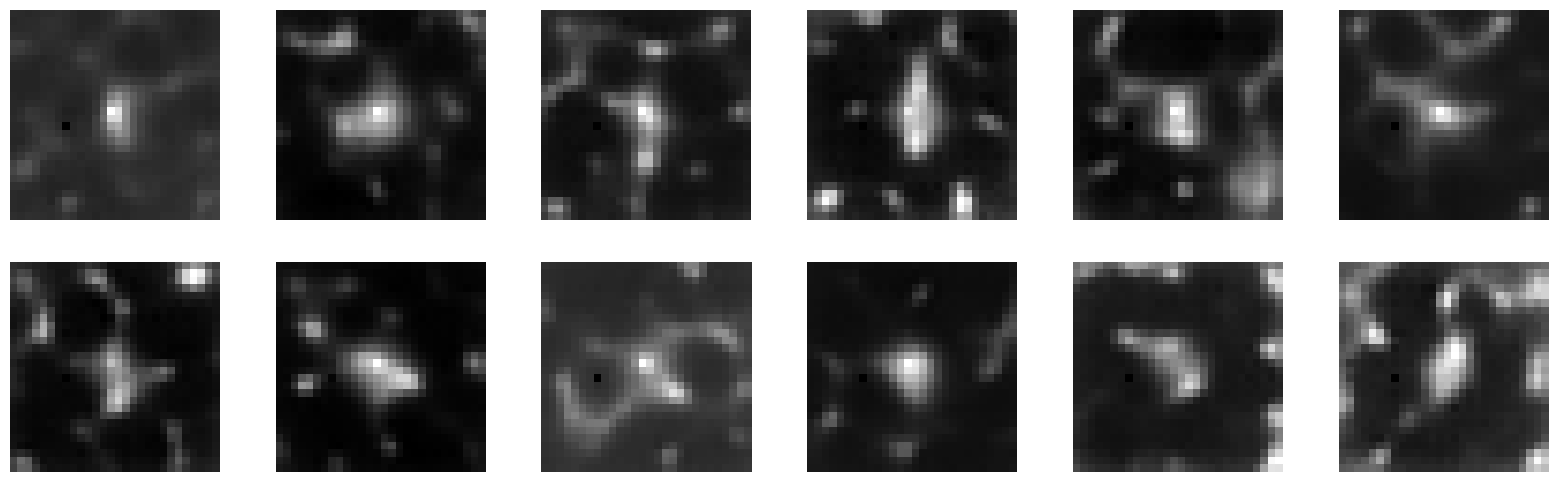

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(20, 6))
for i in range(6):
  axs[0, i].imshow(np.transpose(img_def[i], (1, 2, 0)),cmap='gray')
  axs[0, i].axis('off')
  axs[1, i].imshow(np.transpose(img_def[i+6], (1, 2, 0)),cmap='gray')
  axs[1, i].axis('off')

plt.show()



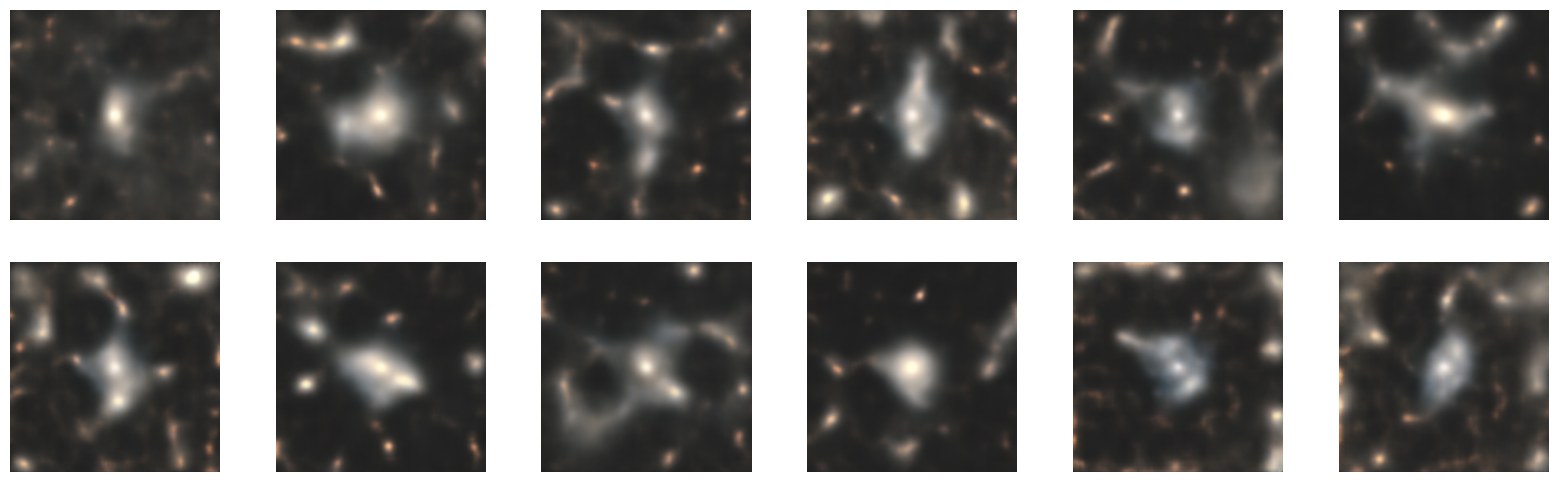

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(20, 6))
for i in range(6):
  axs[0, i].imshow((img_findef[i]),cmap='gray')
  axs[0, i].axis('off')
  axs[1, i].imshow((img_findef[i+6]),cmap='gray')
  axs[1, i].axis('off')
plt.show()